<a href="https://colab.research.google.com/github/pepetonof/IC-ENC-2024/blob/main/tutorial_IC_ENC_2024_TSP.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
user = "pepetonof"
repo = "IC-ENC-2024"
src_dir = "blob"
file = "ciudadescoordnames.txt"
url = f"https://raw.githubusercontent.com/{user}/{repo}/main/{file}"
!wget --no-cache --backups=0 {url}
!git clone https://github.com/jschleuss/mexican-states.git

--2024-09-23 16:27:31--  https://raw.githubusercontent.com/pepetonof/IC-ENC-2024/main/ciudadescoordnames.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 933 [text/plain]
Saving to: ‘ciudadescoordnames.txt’

ciudadescoordnames. 100%[===================>]     933  --.-KB/s    in 0s      

2024-09-23 16:27:32 (32.1 MB/s) - ‘ciudadescoordnames.txt’ saved [933/933]

Cloning into 'mexican-states'...
remote: Enumerating objects: 25, done.
remote: Counting objects: 100% (4/4), done.
remote: Total 25 (delta 3), reused 3 (delta 3), pack-reused 21 (from 1)
Receiving objects: 100% (25/25), 7.02 MiB | 25.31 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [ ]:
!pip install haversine
!pip install geopandas
!pip install deap

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.4/135.4 kB 3.4 MB/s eta 0:00:00


In [ ]:
import math
import random
from haversine import haversine
import itertools
from itertools import permutations
import matplotlib.pyplot as plt
import geopandas as gpd

from deap import algorithms
from deap import base
from deap import creator
from deap import tools
import numpy as np

In [ ]:
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

#Se crea un diccionario con basse en la información .txt
dic_coordgeo={}
with open("ciudadescoordnames.txt", "r") as f:
    for line in f.readlines():
        line=line.split()
        if len(line)==3:
            dic_coordgeo[line[0]]=(float(line[1]),float(line[2]))
        elif len(line)==4:
            dic_coordgeo[line[0]+" "+line[1]]=(float(line[2]),float(line[3]))
        elif len(line)>4:
            dic_coordgeo[line[0]+" "+line[1]+" "+line[2]]=(float(line[3]),float(line[4]))

ciudades=list(dic_coordgeo.keys())
toolbox = base.Toolbox()
toolbox.register("permutation", random.sample, range(len(ciudades)), len(ciudades)) #
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.permutation)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def sol2cities(sol):
  return [ciudades[i] for i in sol]

def geomex(rutaop,titulo):
    rutaop = [ciudades[i] for i in rutaop] #convert to a list of cities
    mex=gpd.read_file("mexican-states/mexican-states.shp")
    fig,ax=plt.subplots(1,1,figsize=(10,8))
    mex.plot(ax=ax,color='white',edgecolor='black')

    #Coloca puntos de las ciudades a recorrer y la ruta entre ellas
    for i in range(len(rutaop)):
        lat1=dic_coordgeo[rutaop[i%len(rutaop)]][0]
        lon1=dic_coordgeo[rutaop[i%len(rutaop)]][1]
        if i==0:
            plt.plot(lon1,lat1, marker="o", color="green")
        else:
            plt.plot(lon1,lat1, marker="o", color="red")

        lat2=dic_coordgeo[rutaop[(i+1)%len(rutaop)]][0]
        lon2=dic_coordgeo[rutaop[(i+1)%len(rutaop)]][1]
        plt.plot([lon1,lon2],[lat1,lat2],'b')
        plt.title(titulo)

# Recibe una lista de nombres de ciudades como una solución
def fitness(solucion):
    def distancia(tupla1,tupla2):
      dist=haversine(tupla1,tupla2)
      return dist

    costo=0
    #convert to a list of cities instead of numbers
    solucion = sol2cities(solucion)
    for i in range(len(solucion)):
        #comput
        costo+=distancia(dic_coordgeo[solucion[i%len(solucion)]],dic_coordgeo[solucion[(i+1)%len(solucion)]])

    return costo,

toolbox.register("evaluate", fitness)
toolbox.register("mate", tools.cxPartialyMatched)

def mutate(ind):
    lim1=random.randint(2, len(ind)-1)
    lim2=random.randint(0, len(ind)-lim1)
    ind[lim1:lim1+lim2]=reversed(ind[lim1:lim1+lim2])

    return ind,

#toolbox.register("mutate", tools.mutShuffleIndexes, indpb = 2.0/len(ciudades))
toolbox.register("mutate", mutate)
toolbox.register("select", tools.selTournament, tournsize=3)

# Algoritmo Genético

In [ ]:
stats_fit = tools.Statistics(lambda ind: ind.fitness.values[0])
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("avg", np.mean)
stats.register("std", np.std)
stats.register("min", np.min)
stats.register("max", np.max)

def varAnd(population, toolbox, cxpb, mutpb):
    offspring = [toolbox.clone(ind) for ind in population]
    # Apply crossover and mutation on the offspring
    for i in range(1, len(offspring), 2):
        if random.random() < cxpb:
            offspring[i - 1], offspring[i] = toolbox.mate(offspring[i - 1],
                                                          offspring[i])
            del offspring[i - 1].fitness.values, offspring[i].fitness.values

    for i in range(len(offspring)):
        if random.random() < mutpb:
            offspring[i], = toolbox.mutate(offspring[i])
            del offspring[i].fitness.values

    return offspring

def ea(population, toolbox, cxpb, mutpb, ngen, stats=None,
             halloffame=None, verbose=__debug__):
  logbook = tools.Logbook()
  logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])

  # Evaluate the individuals with an invalid fitness
  invalid_ind = [ind for ind in population if not ind.fitness.valid]
  fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
  for ind, fit in zip(invalid_ind, fitnesses):
      ind.fitness.values = fit

  if halloffame is not None:
      halloffame.update(population)

  record = stats.compile(population) if stats else {}
  logbook.record(gen=0, nevals=len(invalid_ind), **record)
  if verbose:
      print(logbook.stream)

  # Begin the generational process
  for gen in range(1, ngen + 1):
      # Select the next generation individuals
      offspring = toolbox.select(population, len(population))

      # Vary the pool of individuals
      offspring = varAnd(offspring, toolbox, cxpb, mutpb)

      # Evaluate the individuals with an invalid fitness
      invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
      fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
      for ind, fit in zip(invalid_ind, fitnesses):
          ind.fitness.values = fit

      # Update the hall of fame with the generated individuals
      if halloffame is not None:
          halloffame.update(offspring)

      # Replace the current population by the offspring
      population[:] = offspring

      # Append the current generation statistics to the logbook
      record = stats.compile(population) if stats else {}
      logbook.record(gen=gen, nevals=len(invalid_ind), **record)
      if verbose:
          print(logbook.stream)

  return population, logbook

In [ ]:
pop = toolbox.population(n=200)
hof = tools.HallOfFame(10)
pop, log = ea(pop, toolbox, 0.4, 0.2, 2000, stats=stats,
              halloffame=hof, verbose=True)

gen	nevals	avg    	std    	min    	max    
0  	200   	27514.3	1967.46	21222.4	31837.1
1  	115   	26220.8	1950.64	20817.2	30660  
2  	97    	25282.8	1911.09	21072.3	31393  
3  	93    	24474.9	2008.19	20896.2	31629.9
4  	100   	23789.5	1964.83	20896.2	29854.2
5  	103   	23239.6	1921.04	20425.8	30615.3
6  	102   	22944.4	1939.65	20321.6	29331.5
7  	105   	22664  	1969.24	20321.6	31322.8
8  	96    	22059.2	1636.57	19841.4	30216  
9  	131   	22054.6	2071.18	19768.1	30760.1
10 	108   	21363  	1575.34	18545.4	28288.3
11 	93    	21330.9	1929.7 	18545.4	29937.6
12 	103   	20572.2	1047.76	18397.7	25317.4
13 	97    	20311.5	1096.22	17982.5	26225  
14 	103   	20086  	1133   	18025  	25492.1
15 	93    	19807.4	1181.33	17459.6	24374.5
16 	87    	19568.5	1283.84	17450.8	25379.2
17 	120   	19288  	1719.16	16477.6	28227.4
18 	93    	18687.1	1366.66	15827.5	25185.8
19 	114   	18427.5	1316.54	15827.5	23751.5
20 	110   	18197.2	1511.66	15827.5	24580.5
21 	98    	17857.4	1339.09	15827.5	23304.6
22 	115   	

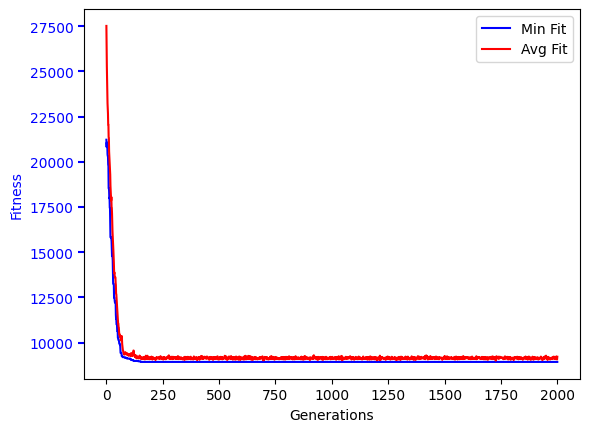

In [ ]:
def convergence_graph(logbook, name):
  gen=logbook.select("gen")
  fit_max=logbook.select("min")
  fit_avg=logbook.select("avg")
  fig, host = plt.subplots()
  p1, = host.plot(gen, fit_max, "b-", label="Min Fit")
  p2, = host.plot(gen, fit_avg, "r-", label="Avg Fit")
  host.set_xlabel("Generations")
  host.set_ylabel("Fitness")
  host.yaxis.label.set_color(p1.get_color())
  tkw = dict(size=4, width=1.5)
  host.tick_params(axis='y', colors=p1.get_color(), **tkw)
  lines = [p1,p2]

  host.legend(lines, [l.get_label() for l in lines], loc="upper right")
  # fig.savefig(ruta+"/Convergencia.png")
  fig.savefig("./"+name)
  # plt.close(fig)
  plt.show()

convergence_graph(log, "GraficaConvergencia")

[31, 0, 24, 12, 11, 25, 7, 18, 22, 27, 2, 8, 5, 19, 28, 29, 3, 15, 1, 30, 21, 26, 20, 6, 17, 23, 4, 13, 16, 14, 9, 10] (8935.539852447013,)
['Zacatecas', 'Aguascalientes', 'San Luis Potosi', 'Guanajuato', 'Guadalajara', 'Tepic', 'Colima', 'Morelia', 'Queretaro', 'Toluca', 'Cdmx', 'Cuernavaca', 'Chilpancingo', 'Oaxaca', 'Tuxtla Gutierrez', 'Villahermosa', 'Chetumal', 'Merida', 'Campeche', 'Xalapa', 'Puebla', 'Tlaxcala', 'Pachuca', 'Ciudad Victoria', 'Monterrey', 'Saltillo', 'Chihuahua', 'Hermosillo', 'Mexicali', 'La Paz', 'Culiacan', 'Durango']


/usr/local/lib/python3.10/dist-packages/pyogrio/raw.py:196: RuntimeWarning: mexican-states/mexican-states.shp contains polygon(s) with rings with invalid winding order. Autocorrecting them, but that shapefile should be corrected using ogr2ogr for example.
  return ogr_read(


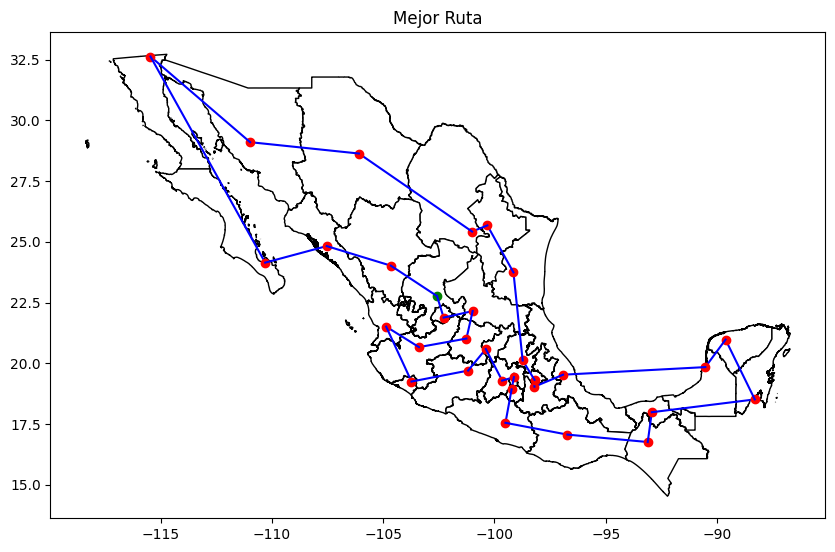

In [ ]:
#plot the optimal route
best = tools.selBest(pop, 1)[0]
print(best, best.fitness.values)
print(sol2cities(best))
geomex(best, "Mejor Ruta")